In [1]:
# imports
import wrangle_zillow as wr
import explore_zillow as ex
import evaluate_zillow as ev

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

Load in successful, awaiting commands...


<div class="alert alert-block alert-info"> 
    
# Wrangle

In [2]:
# get data
df = wr.get_zillow_261()

CSV file found and loaded


In [3]:
# identify outliers
wr.outliers_zillow(df, 1.5)

Bedroomcnt: upper,lower (5.5, 1.5)
Bathroomcnt: upper,lower (4.5, 0.5)
Calculatedfinishedsquarefeet: upper,lower (3634.5, -169.5)
Taxvaluedollarcnt: upper,lower (1054062.125, -331364.875)
Yearbuilt: upper,lower (2016.5, 1908.5)
Taxamount: upper,lower (12233.329999999998, -3284.0299999999993)
Fips: upper,lower (6092.0, 6004.0)
Propertylandusetypeid: upper,lower (261.0, 261.0)
Parcelid: upper,lower (17651612.5, 8063540.5)
---


In [4]:
# clean data
df_clean = wr.wrangle_zillow(df)

Returning Zillow's Single Family Residential Homes from 2017
--------------------------------------------
Renamed columns for ease of use
NaN's removed: Percent Original Data Remaining: 99.0
Moved target column to index 0 for ease of assignment
Bed and year data types changed from float to integer
Changed FIPS code to actual county name
Outliers removed: Percent Original Data Remaining: 91.0
 Sqft <= 5,000 and > 0
 Property Taxes <= $12,233 and > 0
 Bathrooms <= 5 and > 0
 Bedrooms <= 6 and > 0
 Built after 1908
 Assessed Worth <= $1,054,062 and > 0
Encoded County column and renamed encoded columns for readability
DataFrame is clean and ready for exploration :)


In [5]:
# split data
train, validate, test = wr.split_zillow(df_clean)

Prepared DF: (1957985, 8)
Train: (1096471, 8)
Validate: (469917, 8)
Test: (391597, 8)


In [6]:
# prepare data for modeling (dropped target and property taxes b/c dervied from target)
X_train, y_train, X_validate, y_validate, X_test, y_test = \
wr.x_y_train_validate_test(train, validate, test, 'assessed_worth', 'property_taxes')

Variable assignment successful...
Verifying number of features and target:
Train: ((1096471, 6), (1096471, 1))
Validate: ((469917, 6), (469917, 1))
Test: ((391597, 6), (391597, 1))


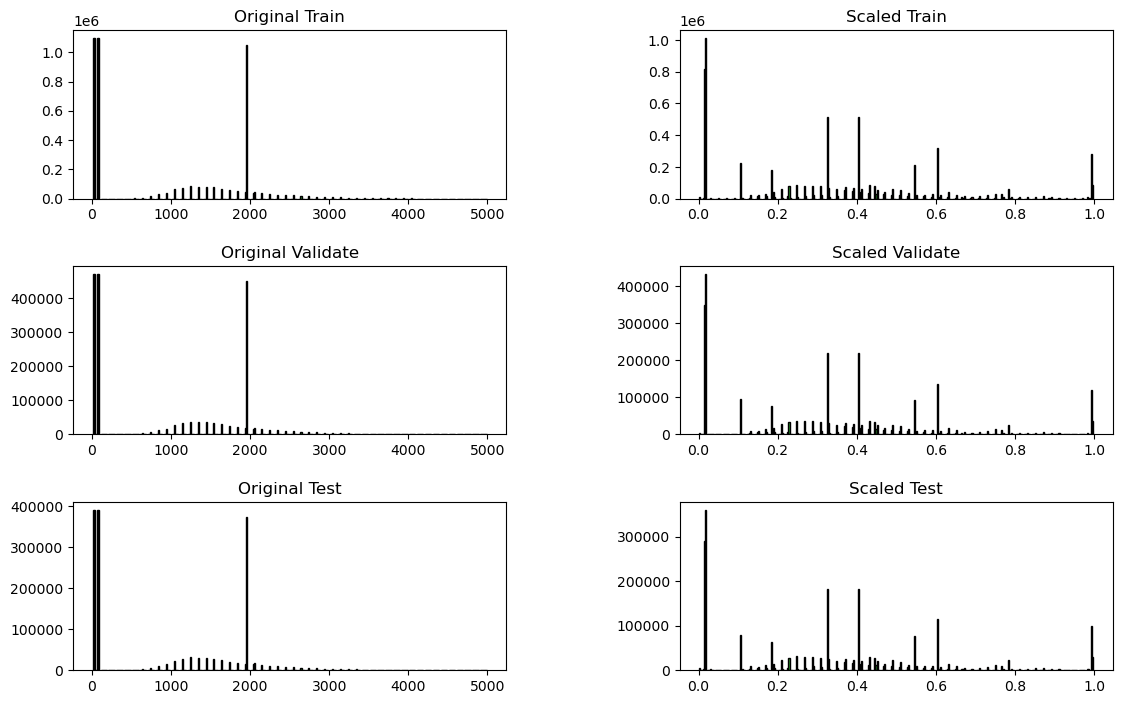

In [7]:
# scale data
X_train_scaled_mm, X_validate_scaled_mm, X_test_scaled_mm = wr.scale_zillow_2(X_train, X_validate, X_test)

<div class="alert alert-block alert-info"> 
    
# Explore

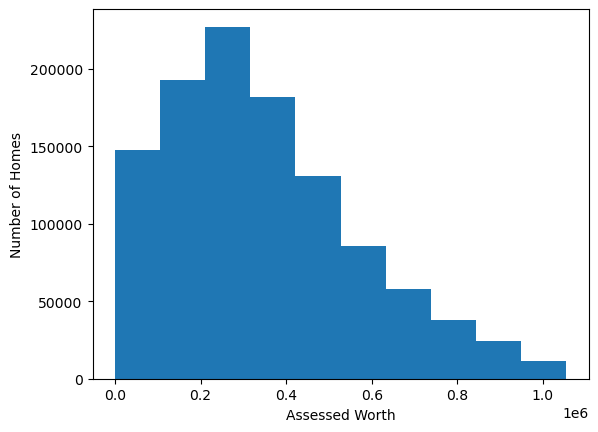

In [8]:
# looking at the target variable to see which algorithm we may want to use
# lokos to be mostly normal, right skewed
plt.hist(y_train)
plt.xlabel("Assessed Worth")
plt.ylabel("Number of Homes")
plt.show()

In [9]:
# baseline
baseline = y_train.mean().round(4)
baseline

assessed_worth    346887.7175
dtype: float64

In [10]:
def metrics_reg(y, baseline):
    """
    send in y_true, y_pred & returns RMSE, R2 --Misty's
    """
    rmse = mean_squared_error(y, baseline, squared=False)
    r2 = r2_score(y, baseline)
    return rmse, r2

In [11]:
# make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(X_train_scaled_mm))
baseline_array[:5]

assessed_worth    346887.7175
assessed_worth    346887.7175
assessed_worth    346887.7175
assessed_worth    346887.7175
assessed_worth    346887.7175
dtype: float64

In [12]:
X_train_scaled_mm.shape, y_train.shape

((1096471, 6), (1096471, 1))

In [13]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2

(219530.3682353831, -2.220446049250313e-16)

In [14]:
# create a metrics DF to compare all scores at the end during evaluation
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'RMSE':rmse.round(2),
        'R2':r2
    }
    
])
metrics_df

,model,RMSE,R2
0,baseline,219530.37,-2.220446e-16


In [15]:
# We need y_train and y_validate to be dataframes to append the new columns with 
# predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict assessed_worth_pred_mean
y_train['assessed_worth_pred_mean'] = y_train['assessed_worth'].mean()
y_validate['assessed_worth_pred_mean'] = y_validate['assessed_worth'].mean()

# 2. compute assessed_worth_pred_median
y_train['assessed_worth_pred_median'] = y_train['assessed_worth'].median()
y_validate['assessed_worth_pred_median'] = y_validate['assessed_worth'].median()

# 3. RMSE of assessed_worth_pred_mean
rmse_train = mean_squared_error(y_train.assessed_worth, y_train.assessed_worth_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.assessed_worth, y_validate.assessed_worth_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of assessed_worth_pred_median
rmse_train = mean_squared_error(y_train.assessed_worth, y_train.assessed_worth_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.assessed_worth, y_validate.assessed_worth_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  219530.37 
Validate/Out-of-Sample:  219602.61
RMSE using Median
Train/In-Sample:  223173.44 
Validate/Out-of-Sample:  223269.55


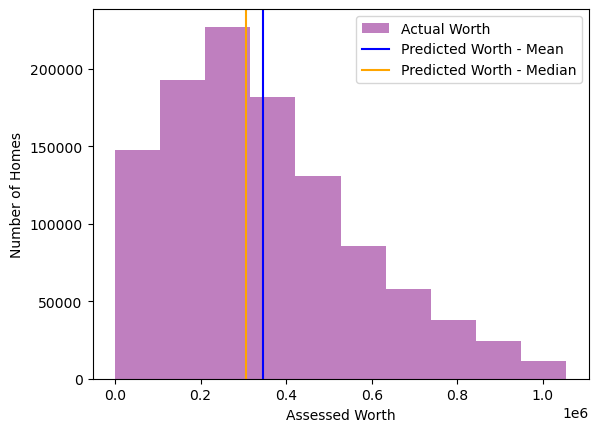

In [16]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.assessed_worth, color='purple', alpha=.5, label="Actual Worth")
plt.axvline(y_train.assessed_worth_pred_mean.mean(), color='blue', label="Predicted Worth - Mean")
plt.axvline(y_train.assessed_worth_pred_median.median(), color='orange', label="Predicted Worth - Median")
plt.xlabel("Assessed Worth")
plt.ylabel("Number of Homes")
plt.legend()
plt.show()

# had to change to a vertical line to be able to see the predicted worth's

<div class="alert alert-block alert-info"> 
    
# Model

<div class="alert alert-block alert-info"> 

### OLS (Linear Regression) - Multiple

* OLS is our standard linear regression algorithm and is computed by minimizing the sum of squared differences in the linear model (residual) with the actual data points

Fit the model using X_train_scaled_mm and the labels from y_train.

Predict final grade for students in training sample using our model (lr).

Evaluate using RMSE, R2

Repeat predictions and evaluation for validation.

Add Validation RMSE, R2 to metrics_df
    
* Compare RMSE train vs. validation. Overfitting
* no overfitting, values for train and validate are very close

In [17]:
# create the model object
lr = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lr.fit(X_train_scaled_mm, y_train.assessed_worth)

# predict train
y_train['worth_pred_lr'] = lr.predict(X_train_scaled_mm)

    # evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_worth, y_train.worth_pred_lr)**(1/2)

# predict validate
y_validate['worth_pred_lr'] = lr.predict(X_validate_scaled_mm)

    # evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_worth, y_validate.worth_pred_lr)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train.round(4), 
      "\nValidation/Out-of-Sample: ", rmse_validate.round(4))
print(f"Difference of Train and Validate RMSE: {round(np.absolute(rmse_train.round(4) - rmse_validate.round(4)),4)}")

RMSE for OLS using LinearRegression
Training/In-Sample:  189898.2045 
Validation/Out-of-Sample:  190127.9342
Difference of Train and Validate RMSE: 229.7297


In [18]:
# train
metrics_reg(y_train.assessed_worth, y_train.worth_pred_lr)

(189898.2045400169, 0.25174004174757325)

In [19]:
# validate
rmse, r2 = metrics_reg(y_validate.assessed_worth, y_validate.worth_pred_lr)
rmse, r2

(190127.9342085145, 0.25042195450393556)

In [20]:
# add to metrics_df
metrics_df.loc[1] = ['OLS', rmse.round(2), r2]
metrics_df

,model,RMSE,R2
0,baseline,219530.37,-2.220446e-16
1,OLS,190127.93,2.504220e-01


<div class="alert alert-block alert-info"> 

### LassoLars

LASSO = Least Absolute Shrinkage and Selection Operator

LARS = Least Angle Regression

* Performs intrinsic feature selection and noise reduction to avoid overfitting
* The most important hyperparameter is alpha
    * Alpha determines the degree of regularization applied to the model
    * The lowest alpha is zero, and this represents no regularization (identical to OLS)
    * There is no limit to alpha, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero
    * Generally speaking, the higher the alpha, the lower your risk for overfitting
alpha = 1.0 is a good place to start.

Fit the model using X_train_scaled_mm and the labels from y_train.

Predict final grade for students in training sample using our model (lars).

Evaluate using RMSE, R2

Repeat predictions and evaluation for validation.

Add Validation RMSE, R2 to metrics_df
* Compare RMSE train vs. validation. Overfitting
* no overfitting, values for train and validate are very close

In [21]:
# create the model object
lars = LassoLars(alpha=1)   # alpha = 0 is just linear regression

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled_mm, y_train.assessed_worth)

# predict train
y_train['worth_pred_lars'] = lars.predict(X_train_scaled_mm)

    # evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_worth, y_train.worth_pred_lars)**(1/2)

# predict validate
y_validate['worth_pred_lars'] = lars.predict(X_validate_scaled_mm)

    # evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_worth, y_validate.worth_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train.round(4), 
      "\nValidation/Out-of-Sample: ", rmse_validate.round(4))
print(f"Difference of Train and Validate RMSE: {round(np.absolute(rmse_train.round(4) - rmse_validate.round(4)),4)}")

RMSE for Lasso + Lars
Training/In-Sample:  189922.7917 
Validation/Out-of-Sample:  190149.6703
Difference of Train and Validate RMSE: 226.8786


In [22]:
# looking at the coef weights assigned to each feature
pd.Series(lars.coef_, index=X_train.columns)

bed       -145491.692364
bath       125785.974785
sqft       742959.405059
year        19002.125845
orange      41268.893982
ventura     19357.161085
dtype: float64

In [23]:
# train
metrics_reg(y_train.assessed_worth, y_train.worth_pred_lars)

(189922.79171678532, 0.2515462664464677)

In [24]:
# validate
rmse, r2 = metrics_reg(y_validate.assessed_worth, y_validate.worth_pred_lars)
rmse, r2

(190149.67028331113, 0.2502505560625675)

In [26]:
# add to metrics df
metrics_df.loc[2] = ['LARS',rmse.round(2), r2]
metrics_df

,model,RMSE,R2
0,baseline,219530.37,-2.220446e-16
1,OLS,190127.93,2.504220e-01
2,LARS,190149.67,2.502506e-01


<div class="alert alert-block alert-info"> 

### TweedieRegressor (Generalized Linear Model)

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the TweedieRegressor method to create a GLM using sklearn.

About power:
- power = 0: Normal Distribution
- power = 1: Poisson Distribution
- power = (1,2): Compound Distribution
- power = 2: Gamma Distribution
- power = 3: Inverse Gaussian Distribution

Fit the model using X_train_scaled_mm and the labels from y_train.

Predict worth for house in training sample using our model (glm).

Evaluate using RMSE, R2

Repeat predictions and evaluation for validation.

Add Validation RMSE, R2 to metrics_df
* Compare RMSE train vs. validation. Overfitting
* no overfitting, values for train and validate are very close

In [51]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)  # power = distribution, alpha = 0: linear reg

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled_mm, y_train.assessed_worth)

# predict train
y_train['worth_pred_glm'] = glm.predict(X_train_scaled_mm)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_worth, y_train.worth_pred_glm)**(1/2)

# predict validate
y_validate['worth_pred_glm'] = glm.predict(X_validate_scaled_mm)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_worth, y_validate.worth_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=0\nTraining/In-Sample: ", rmse_train.round(4), 
      "\nValidation/Out-of-Sample: ", rmse_validate.round(4))
print(f"Difference of Train and Validate RMSE: {round(np.absolute(rmse_train.round(4) - rmse_validate.round(4)),4)}")

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  190794.5365 
Validation/Out-of-Sample:  191008.2585
Difference of Train and Validate RMSE: 213.722


In [52]:
# train
metrics_reg(y_train.assessed_worth, y_train.worth_pred_glm)

(190794.53646603005, 0.24465969952117794)

In [53]:
# validate
rmse, r2 = metrics_reg(y_validate.assessed_worth, y_validate.worth_pred_glm)
rmse, r2

(191008.2584768036, 0.24346454021673014)

In [54]:
# add to metrics df
metrics_df.loc[3] = ['GLM',rmse.round(2),r2]
metrics_df

,model,RMSE,R2
0,baseline,219530.37,-2.220446e-16
1,OLS,190127.93,2.504220e-01
2,LARS,190149.67,2.502506e-01
3,GLM,191008.26,2.434645e-01


<div class="alert alert-block alert-info"> 

### Polynomial Regression:
    
* We can introduce higher powers of our independent variables, meaning the model can predict a curve instead of a line
    * The more curves, the more overfitting can occur

**Process:** Create the new features, based on value indicated for degree for train, validate & test. Then, fit the Linear Regression model.

Predict using the transformed (squared or cubed, e.g.) features

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

* no overfitting, values for train and validate are very close

In [104]:
# Polynomial Features

# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled_mm)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled_mm)
X_test_degree3 = pf.transform(X_test_scaled_mm)


In [105]:
# Linear Regression

# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree3, y_train.assessed_worth)

# predict train
y_train['worth_pred_lm2'] = lm2.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_worth, y_train.worth_pred_lm2)**(1/2)

# predict validate
y_validate['worth_pred_lm2'] = lm2.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_worth, y_validate.worth_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=5\nTraining/In-Sample: ", rmse_train.round(4), 
      "\nValidation/Out-of-Sample: ", rmse_validate.round(4))
print(f"Difference of Train and Validate RMSE: {round(np.absolute(rmse_train.round(4) - rmse_validate.round(4)),4)}")

RMSE for Polynomial Model, degrees=5
Training/In-Sample:  186366.0118 
Validation/Out-of-Sample:  186530.9106
Difference of Train and Validate RMSE: 164.8988


In [106]:
# train
metrics_reg(y_train.assessed_worth, y_train.worth_pred_lm2)

(186366.01180062388, 0.27931711035235807)

In [107]:
# validate
rmse, r2 = metrics_reg(y_validate.assessed_worth, y_validate.worth_pred_lm2)
rmse, r2

(186530.91061649425, 0.27851614063131114)

In [108]:
# add to metrics df
metrics_df.loc[4] = ['POLY_3', rmse.round(2), r2]
metrics_df

,model,RMSE,R2
0,baseline,219530.37,-2.220446e-16
1,OLS,190127.93,2.504220e-01
2,LARS,190149.67,2.502506e-01
3,GLM,191008.26,2.434645e-01
4,POLY_3,186530.91,2.785161e-01
5,POLY_5 on test set,185530.01,2.854326e-01


<div class="alert alert-block alert-info"> 
    
# Evaluate
    
Selecting POLY_3 as the best model to use based on performance for the validate set.

In [125]:
# use it
pred_test = lm2.predict(X_test_degree3)
pred_test

# test it
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2

print(f"3rd Degree Polynomial Regression Performance:\n RMSE: ${rmse.round(2)},\n R2: {r2.round(4)}")


3rd Degree Polynomial Regression Performance:
 RMSE: $186116.44,
 R2: 0.2809


In [119]:
# add to metrics_df
metrics_df.loc[5] = ['POLY_3 on test set', rmse.round(2), r2]
metrics_df

,model,RMSE,R2
0,baseline,219530.37,-2.220446e-16
1,OLS,190127.93,2.504220e-01
2,LARS,190149.67,2.502506e-01
3,GLM,191008.26,2.434645e-01
4,POLY_3,186530.91,2.785161e-01
5,POLY_3 on test set,186116.44,2.809082e-01


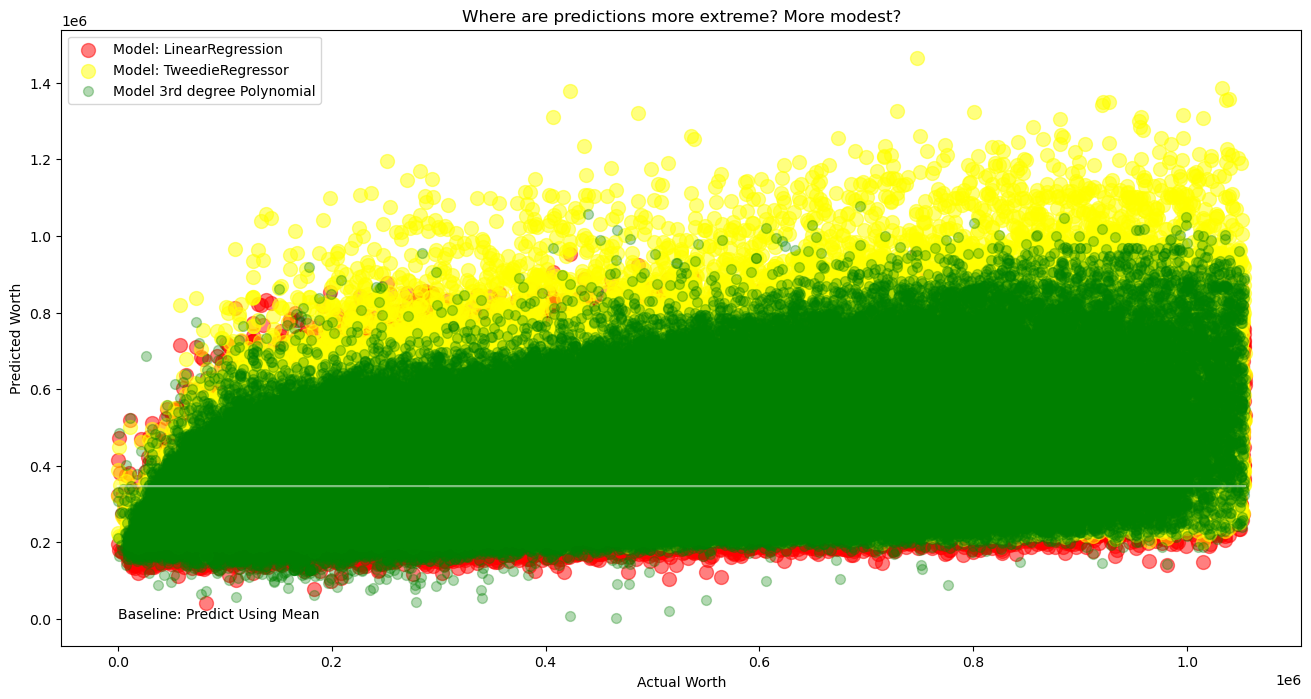

In [111]:
# Plotting actual vs predicted values in validate

# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.assessed_worth, y_validate.assessed_worth_pred_mean, alpha=.5, color="white", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.scatter(y_validate.assessed_worth, y_validate.worth_pred_lr, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.assessed_worth, y_validate.worth_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.assessed_worth, y_validate.worth_pred_lm2, 
            alpha=.3, color="green", s=50, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Worth")
plt.ylabel("Predicted Worth")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


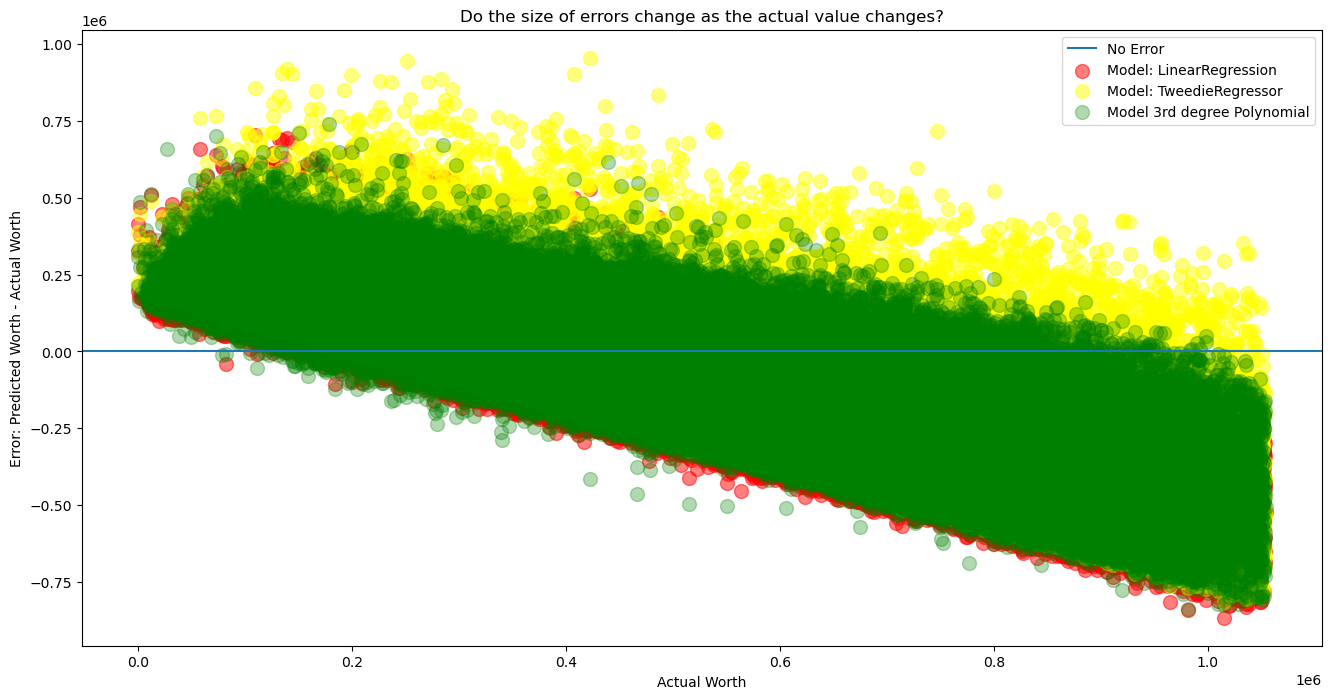

In [113]:
# Residual Plots: Plotting the Errors in Predictions

# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.assessed_worth, y_validate.worth_pred_lr-y_validate.assessed_worth, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.assessed_worth, y_validate.worth_pred_glm-y_validate.assessed_worth, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.assessed_worth, y_validate.worth_pred_lm2-y_validate.assessed_worth, 
            alpha=.3, color="green", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Worth")
plt.ylabel("Error: Predicted Worth - Actual Worth")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()


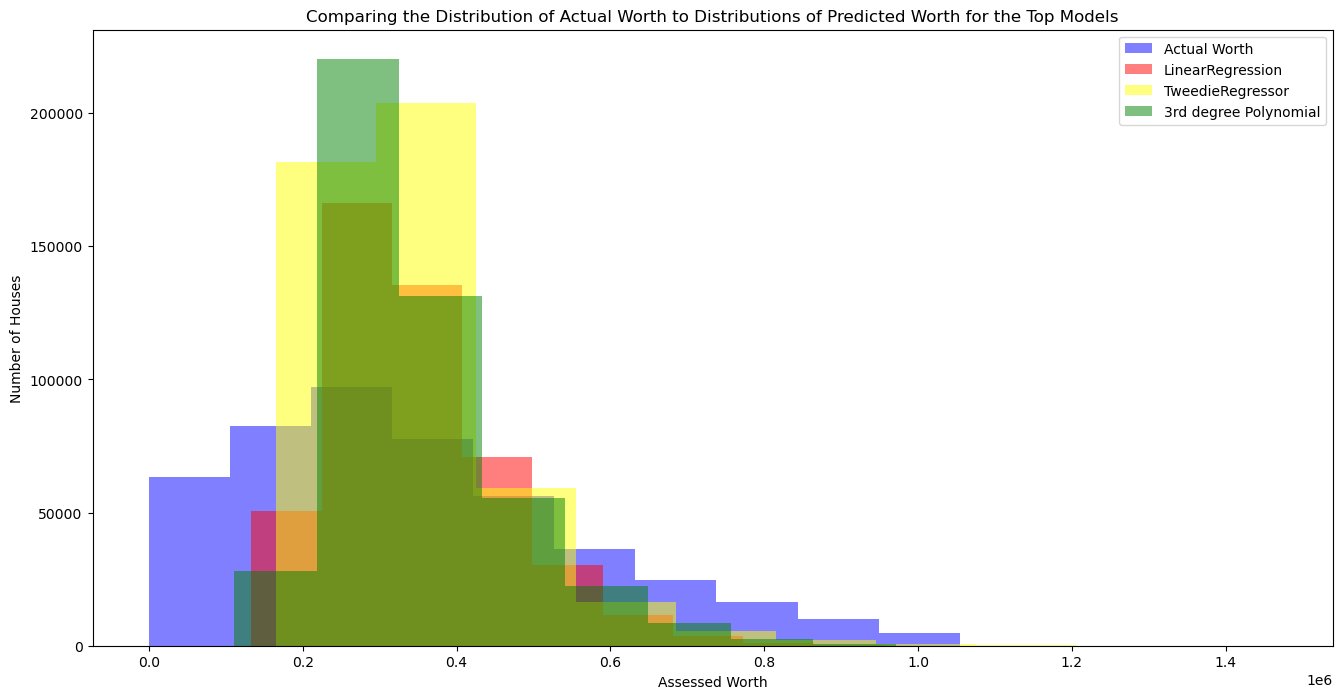

In [114]:
# Histograms

# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.assessed_worth, color='blue', alpha=.5, label="Actual Worth")
plt.hist(y_validate.worth_pred_lr, color='red', alpha=.5, label="LinearRegression")
plt.hist(y_validate.worth_pred_glm, color='yellow', alpha=.5, label="TweedieRegressor")
plt.hist(y_validate.worth_pred_lm2, color='green', alpha=.5, label="3rd degree Polynomial")
plt.xlabel("Assessed Worth")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Actual Worth to Distributions of Predicted Worth for the Top Models")
plt.legend()
plt.show()


<div class="alert alert-block alert-info"> 
 
### Test
    
Run through entire modeling process on test set:
    
* Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

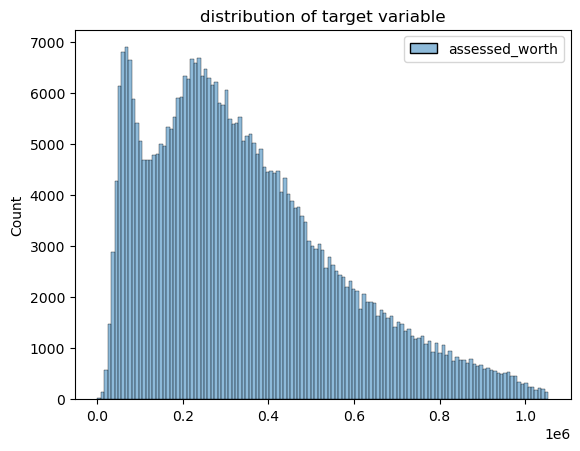

In [129]:
# look at the test set
sns.histplot(y_test)
plt.title('distribution of target variable')
plt.show()

In [131]:
# baseline
baseline = y_test.mean().round(2)
baseline

assessed_worth    346727.71
dtype: float64

In [132]:
# make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(test))
baseline_array[:5]

assessed_worth    346727.71
assessed_worth    346727.71
assessed_worth    346727.71
assessed_worth    346727.71
assessed_worth    346727.71
dtype: float64

In [133]:
rmse, r2 = metrics_reg(y_test, baseline_array)
rmse, r2

(219478.79899831806, -2.220446049250313e-16)

In [136]:
# make test df
metrics_test = pd.DataFrame(data=[
    {
        'Model':'Test Baseline',
        'RMSE':rmse,
        'R2':r2
    }
    
])
metrics_test

,Model,RMSE,R2
0,Test Baseline,219478.798998,-2.220446e-16


In [137]:
# We need y_test to be a dataframe to append the new columns with 
# predicted values. 
y_test = pd.DataFrame(y_test)

# 1. Predict assessed_worth_pred_mean
y_test['assessed_worth_pred_mean'] = y_test['assessed_worth'].mean()

# 2. compute assessed_worth_pred_median
y_test['assessed_worth_pred_median'] = y_test['assessed_worth'].median()

# 3. RMSE of assessed_worth_pred_mean
rmse_test = mean_squared_error(y_test.assessed_worth, y_test.assessed_worth_pred_mean)**(1/2)

print(f"RMSE using Mean in Test: {rmse_test.round(2)}")

# 4. RMSE of assessed_worth_pred_median
rmse_test = mean_squared_error(y_test.assessed_worth, y_test.assessed_worth_pred_median)**(1/2)
      
print(f"RMSE using Median in Test: {rmse_test.round(2)}")

RMSE using Mean in Test: 219478.8
RMSE using Median in Test: 223185.25


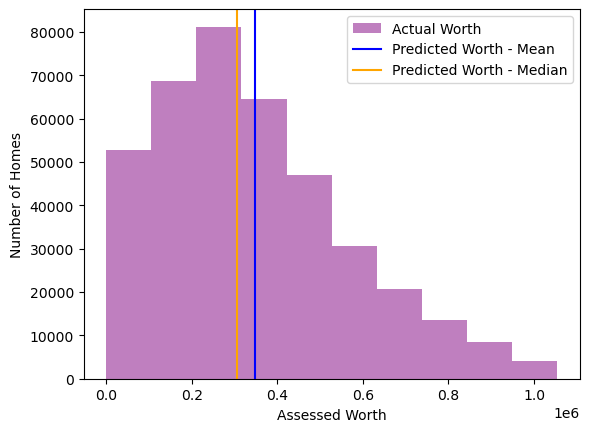

In [138]:
# plot to visualize actual vs predicted. 
plt.hist(y_test.assessed_worth, color='purple', alpha=.5, label="Actual Worth")
plt.axvline(y_test.assessed_worth_pred_mean.mean(), color='blue', label="Predicted Worth - Mean")
plt.axvline(y_test.assessed_worth_pred_median.median(), color='orange', label="Predicted Worth - Median")
plt.xlabel("Assessed Worth")
plt.ylabel("Number of Homes")
plt.legend()
plt.show()

# had to change to a vertical line to be able to see the predicted worth's

<div class="alert alert-block alert-info"> 
    
# Model

<div class="alert alert-block alert-info"> 

### OLS (Linear Regression) - Multiple

* OLS is our standard linear regression algorithm and is computed by minimizing the sum of squared differences in the linear model (residual) with the actual data points

Fit the model using X_test_scaled_mm and the labels from y_test.

Predict final grade for students in training sample using our model (lr).

Evaluate using RMSE, R2 on test set and add to metrics_test df

In [172]:
# create the model object
lr = LinearRegression()

# fit the model to our test data. We must specify the column in y_test, 
# since we have converted it to a dataframe from a series! 
lr.fit(X_test_scaled_mm, y_test.assessed_worth)

# predict train
y_test['worth_pred_lr'] = lr.predict(X_test_scaled_mm)

    # evaluate: rmse
rmse_test = mean_squared_error(y_test.assessed_worth, y_test.worth_pred_lr)**(1/2)

print(f"RMSE for OLS using LinearRegression on Test: ${rmse_test.round(2)}") 

RMSE for OLS using LinearRegression on Test: $189684.35


In [173]:
# test
rmse, r2 = metrics_reg(y_test.assessed_worth, y_test.worth_pred_lr)
rmse, r2

(189684.35354359078, 0.25307350070795753)

In [174]:
# add to metrics_df
metrics_test.loc[1] = ['OLS', rmse.round(2), r2]
metrics_test

,Model,RMSE,R2
0,Test Baseline,219478.798998,-2.220446e-16
1,OLS,189684.350000,2.530735e-01
2,LARS,189693.160000,2.530041e-01
3,GLM,190588.990000,2.459321e-01
4,POLY_3,186090.590000,2.811080e-01


<div class="alert alert-block alert-info"> 

### LassoLars

LASSO = Least Absolute Shrinkage and Selection Operator

LARS = Least Angle Regression

* Performs intrinsic feature selection and noise reduction to avoid overfitting
* The most important hyperparameter is alpha
    * Alpha determines the degree of regularization applied to the model
    * The lowest alpha is zero, and this represents no regularization (identical to OLS)
    * There is no limit to alpha, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero
    * Generally speaking, the higher the alpha, the lower your risk for overfitting
alpha = 1.0 is a good place to start.

Fit the model using X_test_scaled_mm and the labels from y_test.

Predict final grade for students in training sample using our model (lars).

Evaluate using RMSE, R2 on test set and add to metrics_test df

In [151]:
# create the model object
lars = LassoLars(alpha=1)   # alpha = 0 is just linear regression

# fit the model to our test data. We must specify the column in y_test, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_test_scaled_mm, y_test.assessed_worth)

# predict train
y_test['worth_pred_lars'] = lars.predict(X_test_scaled_mm)

    # evaluate: rmse
rmse_test = mean_squared_error(y_test.assessed_worth, y_test.worth_pred_lars)**(1/2)

print(f"RMSE for LassoLars on Test: ${rmse_test.round(2)}")

RMSE for LassoLars on Test: $189693.16


In [145]:
# looking at the coef weights assigned to each feature
pd.Series(lars.coef_, index=X_test.columns)

bed       -145999.786830
bath       122784.461260
sqft       748442.405092
year        23477.756917
orange      41856.942927
ventura     21686.381369
dtype: float64

In [147]:
# validate
rmse, r2 = metrics_reg(y_test.assessed_worth, y_test.worth_pred_lars)
rmse, r2

(189693.1617525291, 0.2530041303324041)

In [154]:
# add to metrics df
metrics_test.loc[2] = ['LARS',round(rmse,2), r2]
metrics_test

,Model,RMSE,R2
0,Test Baseline,219478.798998,-2.220446e-16
1,OLS,189693.160000,2.530041e-01
2,LARS,189693.160000,2.530041e-01


<div class="alert alert-block alert-info"> 

### TweedieRegressor (Generalized Linear Model)

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the TweedieRegressor method to create a GLM using sklearn.

About power:
- power = 0: Normal Distribution
- power = 1: Poisson Distribution
- power = (1,2): Compound Distribution
- power = 2: Gamma Distribution
- power = 3: Inverse Gaussian Distribution

Fit the model using X_test_scaled_mm and the labels from y_test.

Predict worth for house in test set using our model (glm).

Evaluate using RMSE, R2 on test set and add to metrics_test df

In [158]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)  # power = distribution, alpha = 0: linear reg

# fit the model to our test data. We must specify the column in y_test, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_test_scaled_mm, y_test.assessed_worth)

# predict test
y_test['worth_pred_glm'] = glm.predict(X_test_scaled_mm)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.assessed_worth, y_test.worth_pred_glm)**(1/2)

print(f"RMSE for GLM using Tweedie, power=1 & alpha=0 on Test: ${rmse_test.round(2)}")

RMSE for GLM using Tweedie, power=1 & alpha=0 on Test: $190588.99


In [156]:
# validate
rmse, r2 = metrics_reg(y_test.assessed_worth, y_test.worth_pred_glm)
rmse, r2

(190588.99298574205, 0.2459320530810878)

In [157]:
# add to metrics df
metrics_test.loc[3] = ['GLM',rmse.round(2),r2]
metrics_test

,Model,RMSE,R2
0,Test Baseline,219478.798998,-2.220446e-16
1,OLS,189693.160000,2.530041e-01
2,LARS,189693.160000,2.530041e-01
3,GLM,190588.990000,2.459321e-01


<div class="alert alert-block alert-info"> 

### Polynomial Regression:
    
* We can introduce higher powers of our independent variables, meaning the model can predict a curve instead of a line
    * The more curves, the more overfitting can occur

**Process:** Create the new features, based on value indicated for degree for test. Then, fit the Linear Regression model.

Predict using the transformed (squared or cubed, e.g.) features

Evaluate using RMSE, R2 on test set and add to metrics_test df

In [160]:
# Polynomial Features

# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# transform
X_test_degree3 = pf.fit_transform(X_test_scaled_mm)


In [161]:
# Linear Regression

# create the model object
lm2 = LinearRegression()

# fit the model to our test data. We must specify the column in y_test, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_test_degree3, y_test.assessed_worth)

# predict test
y_test['worth_pred_lm2'] = lm2.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.assessed_worth, y_test.worth_pred_lm2)**(1/2)

print(f"RMSE for Polynomial Model, degrees=5 on Test: {rmse_test.round(4)}")

RMSE for Polynomial Model, degrees=5 on Test: 186090.5911


In [162]:
# validate
rmse, r2 = metrics_reg(y_test.assessed_worth, y_test.worth_pred_lm2)
rmse, r2

(186090.5910724701, 0.2811079505975639)

In [163]:
# add to metrics df
metrics_test.loc[4] = ['POLY_3', rmse.round(2), r2]
metrics_test

,Model,RMSE,R2
0,Test Baseline,219478.798998,-2.220446e-16
1,OLS,189693.160000,2.530041e-01
2,LARS,189693.160000,2.530041e-01
3,GLM,190588.990000,2.459321e-01
4,POLY_3,186090.590000,2.811080e-01


<div class="alert alert-block alert-info"> 
    
# Evaluate
    
Selecting POLY_3 as the best model to use based on performance for the test set.

In [165]:
# use it
pred_test = lm2.predict(X_test_degree3)
pred_test

# test it
rmse, r2 = metrics_reg(y_test.assessed_worth, pred_test)
rmse, r2

print(f"3rd Degree Polynomial Regression Performance:\n RMSE: ${rmse.round(2)},\n R2: {r2.round(4)}")


3rd Degree Polynomial Regression Performance:
 RMSE: $186090.59,
 R2: 0.2811


In [166]:
# I don't need to add this to my test set - it's already there
metrics_test

,Model,RMSE,R2
0,Test Baseline,219478.798998,-2.220446e-16
1,OLS,189693.160000,2.530041e-01
2,LARS,189693.160000,2.530041e-01
3,GLM,190588.990000,2.459321e-01
4,POLY_3,186090.590000,2.811080e-01


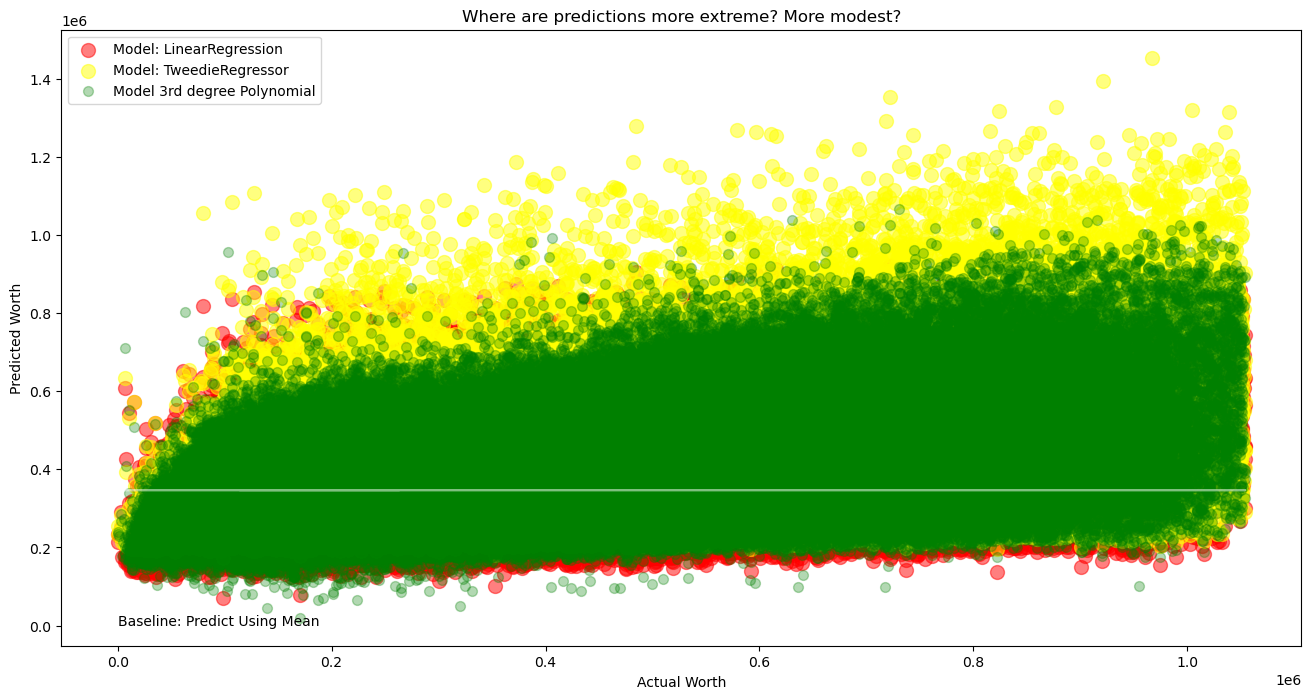

In [168]:
# Plotting actual vs predicted values in test

plt.figure(figsize=(16,8))
plt.plot(y_test.assessed_worth, y_test.assessed_worth_pred_mean, alpha=.5, color="white", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.scatter(y_test.assessed_worth, y_test.worth_pred_lr, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_test.assessed_worth, y_test.worth_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_test.assessed_worth, y_test.worth_pred_lm2, 
            alpha=.3, color="green", s=50, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Worth")
plt.ylabel("Predicted Worth")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


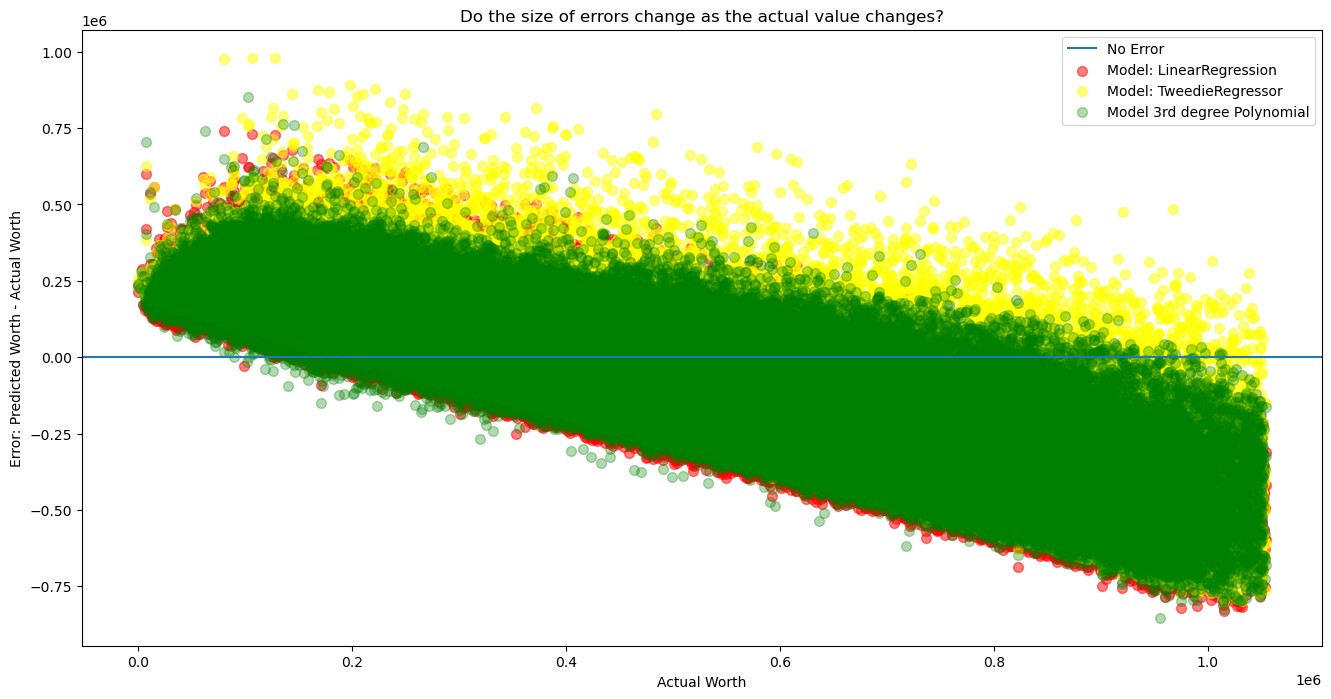

In [170]:
# Residual Plots: Plotting the Errors in Predictions

plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_test.assessed_worth, y_test.worth_pred_lr-y_test.assessed_worth, 
            alpha=.5, color="red", s=50, label="Model: LinearRegression")
plt.scatter(y_test.assessed_worth, y_test.worth_pred_glm-y_test.assessed_worth, 
            alpha=.5, color="yellow", s=50, label="Model: TweedieRegressor")
plt.scatter(y_test.assessed_worth, y_test.worth_pred_lm2-y_test.assessed_worth, 
            alpha=.3, color="green", s=50, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Worth")
plt.ylabel("Error: Predicted Worth - Actual Worth")
plt.title("Do the size of errors change as the actual value changes?")
plt.show()


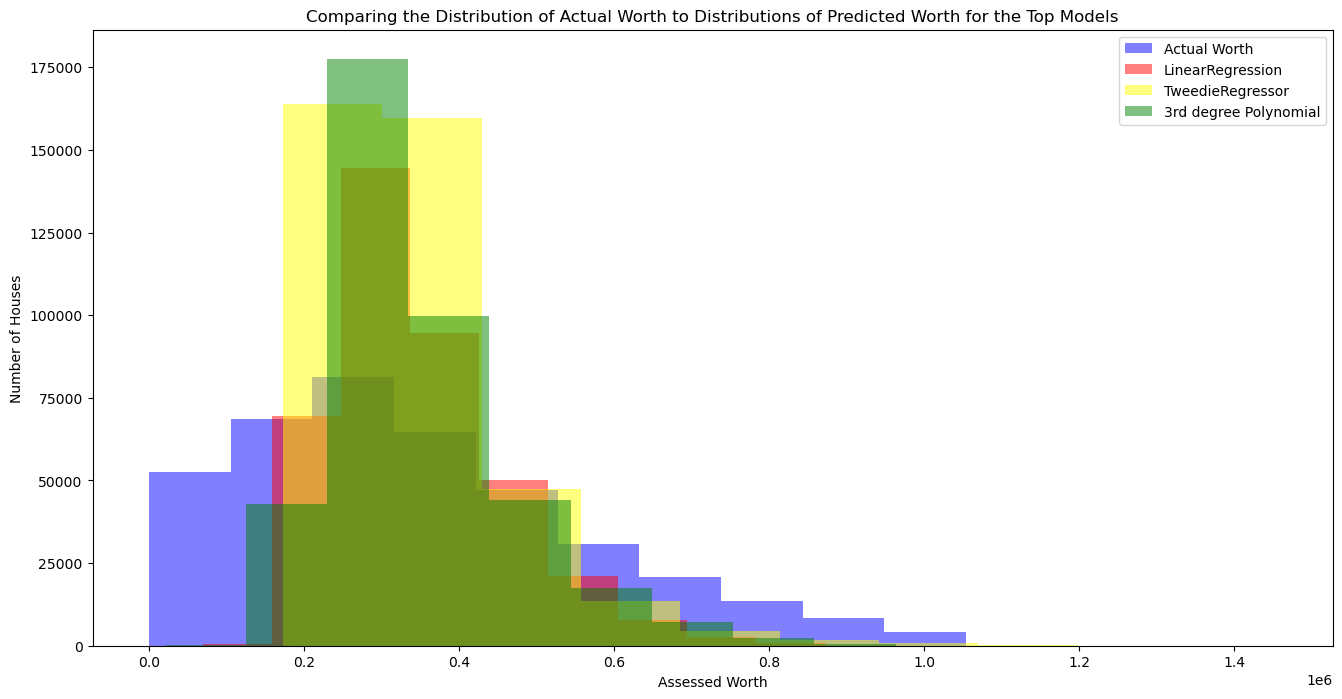

In [171]:
# Histograms

# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_test.assessed_worth, color='blue', alpha=.5, label="Actual Worth")
plt.hist(y_test.worth_pred_lr, color='red', alpha=.5, label="LinearRegression")
plt.hist(y_test.worth_pred_glm, color='yellow', alpha=.5, label="TweedieRegressor")
plt.hist(y_test.worth_pred_lm2, color='green', alpha=.5, label="3rd degree Polynomial")
plt.xlabel("Assessed Worth")
plt.ylabel("Number of Houses")
plt.title("Comparing the Distribution of Actual Worth to Distributions of Predicted Worth for the Top Models")
plt.legend()
plt.show()
